In [154]:
# PREAMBLE
%matplotlib inline

import re
import io
import os.path
from functools import reduce

import pandas as pd

import numpy as np

from ggplot import *

In [155]:
### Network I/O

In [156]:
# PROCESS SAR METRICS
FIND_ETH0 = re.compile(".+ ens3 .+")
FIND_CPU = re.compile(".+ all .+")
BW_COLS = ["ts", "rxpck","txpck","rxkB","txkB"]
CPU_COLS = ["cpu"]
SAMPLES = 5

network_df = lambda fname: pd.read_fwf(io.StringIO("".join(filter(FIND_ETH0.match, open(fname)))), header=None)\
                             .loc[:,[0,3,4,5,6]]
cpu_df = lambda fname: pd.read_fwf(io.StringIO("".join(filter(FIND_CPU.match, open(fname)))), header=None)\
                             .loc[:,[8]]

async_no_ssl_networks = tuple(network_df(os.path.join("reports2", "async_no_ssl_no_sse-network.{}.sar.txt".format(i)))
                              for i in range(1,6))
async_yes_ssl_networks = tuple(network_df(os.path.join("reports2", "async_yes_ssl_no_sse-network.{}.sar.txt".format(i)))
                               for i in range(1,6))
async_yes_sse_networks = tuple(network_df(os.path.join("reports2", "async_yes_ssl_yes_sse-network.{}.sar.txt".format(i)))
                               for i in range(1,6))

async_no_ssl_cpus = tuple(cpu_df(os.path.join("reports2", "async_no_ssl_no_sse-cpu.{}.sar.txt".format(i)))
                          for i in range(1, SAMPLES+1))
async_yes_ssl_cpus = tuple(cpu_df(os.path.join("reports2", "async_yes_ssl_no_sse-cpu.{}.sar.txt".format(i)))
                           for i in range(1, SAMPLES+1))
async_yes_sse_cpus = tuple(cpu_df(os.path.join("reports2", "async_yes_ssl_yes_sse-cpu.{}.sar.txt".format(i)))
                           for i in range(1, SAMPLES+1))

for df in async_no_ssl_networks + async_yes_sse_networks + async_yes_ssl_networks:
    df.columns = BW_COLS

for df in async_no_ssl_cpus + async_yes_sse_cpus + async_yes_ssl_cpus:
    df.columns = CPU_COLS

async_no_ssl_cpu = pd.DataFrame({"s{}".format(i): 100-df.cpu for (i,df) in enumerate(async_no_ssl_cpus, 1)})
async_no_ssl_cpu.df_name = "no_ssl_cpu"
async_yes_ssl_cpu = pd.DataFrame({"s{}".format(i): 100-df.cpu for (i,df) in enumerate(async_yes_ssl_cpus, 1)})
async_yes_ssl_cpu.df_name = "yes_ssl_cpu"
async_yes_sse_cpu = pd.DataFrame({"s{}".format(i): 100-df.cpu for (i,df) in enumerate(async_yes_sse_cpus, 1)})
async_yes_sse_cpu.df_name = "yes_sse_cpu"

async_no_ssl_network = pd.DataFrame({"s{}".format(i): df.txkB for (i,df) in enumerate(async_no_ssl_networks, 1)})
async_no_ssl_network.df_name = "no_ssl_network"
async_yes_ssl_network = pd.DataFrame({"s{}".format(i): df.txkB for (i,df) in enumerate(async_yes_ssl_networks, 1)})
async_yes_ssl_network.df_name = "yes_ssl_network"
async_yes_sse_network = pd.DataFrame({"s{}".format(i): df.txkB for (i,df) in enumerate(async_yes_sse_networks, 1)})
async_yes_sse_network.df_name = "yes_sse_network"

#async_cpu = (async_no_ssl_cpu, async_yes_ssl_cpu, async_yes_sse_cpu)
#async_network = (async_no_ssl_network, async_yes_ssl_network, async_yes_sse_network)
async_cpu = [async_no_ssl_cpu, async_yes_ssl_cpu, async_yes_sse_cpu]
async_network = [async_no_ssl_network, async_yes_ssl_network, async_yes_sse_network]
for i in range(len(async_cpu)):
    df_name = async_cpu[i].df_name
    async_cpu[i]["t"] = async_cpu[i].index
    async_cpu[i] = pd.melt(async_cpu[i], ["t"], var_name="run", value_name=async_cpu[i].df_name)
    async_cpu[i].df_name = df_name
#    df["sample_mean"] = df[list(map("s{}".format, range(1, SAMPLES+1)))].mean(1)

In [157]:
df = pd.melt(reduce(lambda x,y: pd.merge(x, y, on=["t","run"]), async_cpu), 
             id_vars=["t","run"],
             value_name="cpu",
             var_name="run_type",
)

/home/psoutham/.apps/anaconda3/envs/bunnies/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
/home/psoutham/.apps/anaconda3/envs/bunnies/lib/python3.5/site-packages/ggplot/stats/stat_smooth.py:22: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  data = data.sort(['x'])


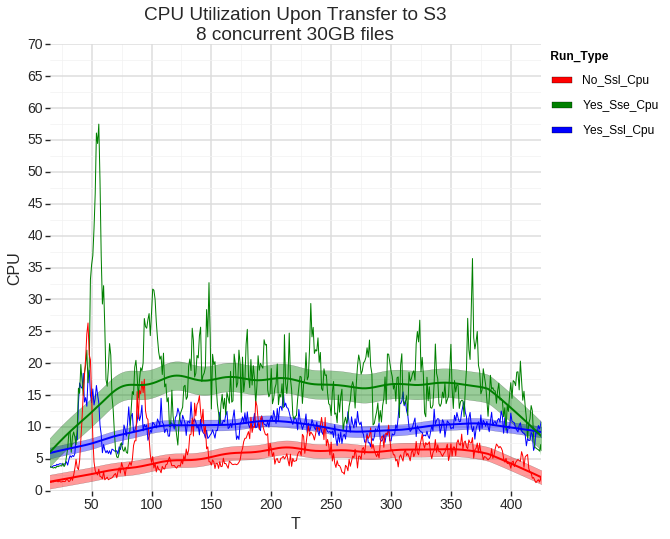

<ggplot: (8734008746437)>

In [158]:
dff =  pd.groupby(df, by=["t","run_type"], exclusions=["run"]).aggregate(np.mean)
data=pd.melt(dff.T, value_name="cpu")
p = ggplot(aes(x='t', y='cpu', color='run_type', fill='run_type'), data=data)
s = p + geom_line() +\
    stat_smooth(size=2, span=0.25) +\
    xlim(15,425) + ylim(0,70) + xlab("T") +\
    ylab("CPU") + ggtitle("CPU Utilization Upon Transfer to S3\n8 concurrent 30GB files") +\
    scale_color_manual(values=["red", "green", "blue"])+theme_seaborn(context='talk',style="whitegrid")
#ggsave("/tmp/foo.png",s,dpi=96)
#data
s

/home/psoutham/.apps/anaconda3/envs/bunnies/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


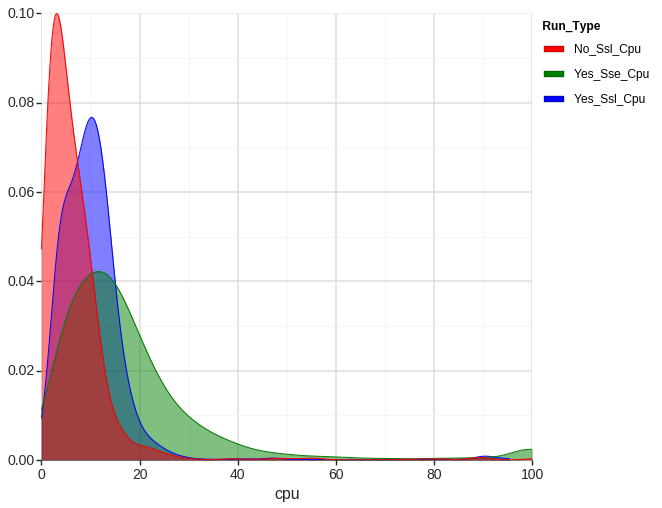

<ggplot: (8734008769470)>

In [159]:
ggplot(aes(x='cpu',  color='run_type', fill='run_type'), data=df) +\
geom_density(alpha=.5)+scale_color_manual(values=["red", "green", "blue"])+theme_seaborn(context='talk',style="whitegrid")

/home/psoutham/.apps/anaconda3/envs/bunnies/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


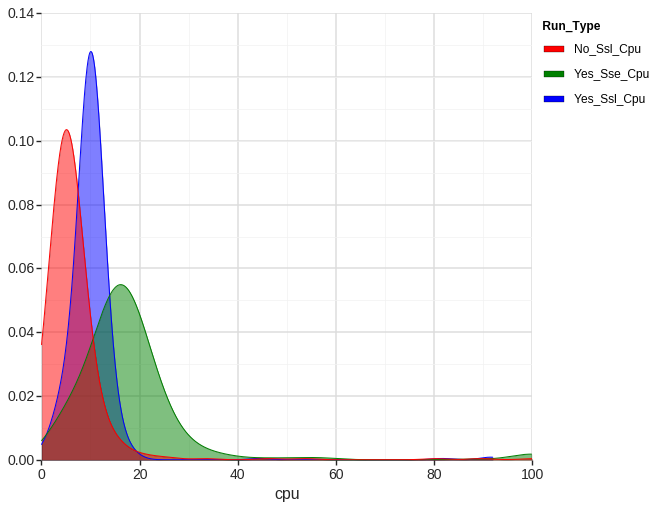

<ggplot: (8734008645005)>

In [160]:
p=ggplot(aes(x='cpu',  color='run_type', fill='run_type'), data=data)
p+ geom_density(alpha=.5)+scale_color_manual(values=["red", "green", "blue"])+theme_seaborn(context='talk',style="whitegrid")

/home/psoutham/.apps/anaconda3/envs/bunnies/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
/home/psoutham/.apps/anaconda3/envs/bunnies/lib/python3.5/site-packages/ggplot/geoms/geom_bar.py:47: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  _reset = self.bottom == None or (self.ax != None and self.ax != ax)


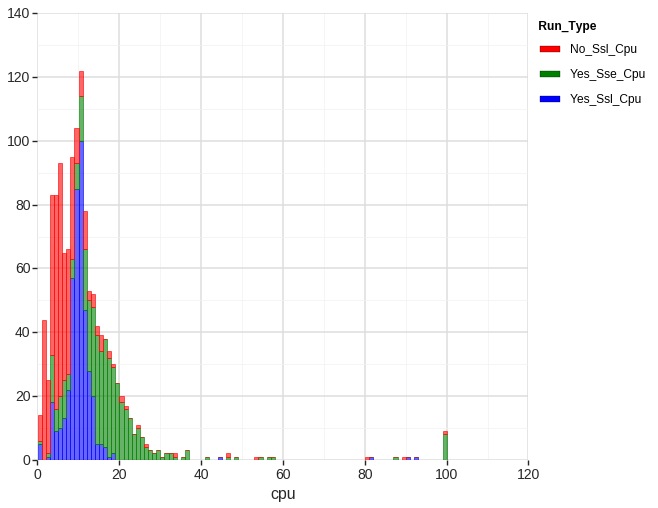

<ggplot: (-9223363302846141475)>

In [161]:
p + geom_histogram(binwidth=1,alpha=.6) +scale_color_manual(values=["red", "green", "blue"])+theme_seaborn(context='talk',style="whitegrid")

In [162]:
# PROCESS SAR METRICS
SAMPLES=8

single_no_ssl_networks = tuple(network_df(os.path.join("reports2", "single_no_ssl_no_sse-network.{}.sar.txt".format(i)))
                              for i in range(0, SAMPLES))
single_yes_ssl_networks = tuple(network_df(os.path.join("reports2", "single_yes_ssl_no_sse-network.{}.sar.txt".format(i)))
                               for i in range(0, SAMPLES))
single_yes_sse_networks = tuple(network_df(os.path.join("reports2", "single_yes_ssl_yes_sse-network.{}.sar.txt".format(i)))
                               for i in range(0, SAMPLES))

single_no_ssl_cpus = tuple(cpu_df(os.path.join("reports2", "single_no_ssl_no_sse-cpu.{}.sar.txt".format(i)))
                          for i in range(0, SAMPLES))
single_yes_ssl_cpus = tuple(cpu_df(os.path.join("reports2", "single_yes_ssl_no_sse-cpu.{}.sar.txt".format(i)))
                           for i in range(0, SAMPLES))
single_yes_sse_cpus = tuple(cpu_df(os.path.join("reports2", "single_yes_ssl_yes_sse-cpu.{}.sar.txt".format(i)))
                           for i in range(0, SAMPLES))

for df in single_no_ssl_networks + single_yes_sse_networks + single_yes_ssl_networks:
    df.columns = BW_COLS

for df in single_no_ssl_cpus + single_yes_sse_cpus + single_yes_ssl_cpus:
    df.columns = CPU_COLS

single_no_ssl_cpu = pd.DataFrame({"s{}".format(i): 100-df.cpu for (i,df) in enumerate(single_no_ssl_cpus)})
single_no_ssl_cpu.df_name = "no_ssl_cpu"
single_yes_ssl_cpu = pd.DataFrame({"s{}".format(i): 100-df.cpu for (i,df) in enumerate(single_yes_ssl_cpus)})
single_yes_ssl_cpu.df_name = "yes_ssl_cpu"
single_yes_sse_cpu = pd.DataFrame({"s{}".format(i): 100-df.cpu for (i,df) in enumerate(single_yes_sse_cpus)})
single_yes_sse_cpu.df_name = "yes_sse_cpu"

single_no_ssl_network = pd.DataFrame({"s{}".format(i): df.txkB for (i,df) in enumerate(single_no_ssl_networks)})
single_no_ssl_network.df_name = "no_ssl_network"
single_yes_ssl_network = pd.DataFrame({"s{}".format(i): df.txkB for (i,df) in enumerate(single_yes_ssl_networks)})
single_yes_ssl_network.df_name = "yes_ssl_network"
single_yes_sse_network = pd.DataFrame({"s{}".format(i): df.txkB for (i,df) in enumerate(single_yes_sse_networks)})
single_yes_sse_network.df_name = "yes_sse_network"

single_cpu = [single_no_ssl_cpu, single_yes_ssl_cpu, single_yes_sse_cpu]
single_network = [single_no_ssl_network, single_yes_ssl_network, single_yes_sse_network]

for i in range(len(single_cpu)):
    df_name = single_cpu[i].df_name
    single_cpu[i]["t"] = single_cpu[i].index
    single_cpu[i] = pd.melt(single_cpu[i], ["t"], var_name="run", value_name=single_cpu[i].df_name)
    single_cpu[i].df_name = df_name

In [163]:
df = pd.melt(reduce(lambda x,y: pd.merge(x.loc[0:95,], y.loc[0:95,], on=["t","run"]), single_cpu), 
             id_vars=["t","run"],
             value_name="cpu",
             var_name="run_type",
)

In [164]:
df[df.run_type == "yes_ssl_cpu"].head()

,t,run,run_type,cpu
96,0,s0,yes_ssl_cpu,0.03
97,1,s0,yes_ssl_cpu,28.10
98,2,s0,yes_ssl_cpu,1.26
99,3,s0,yes_ssl_cpu,1.16
100,4,s0,yes_ssl_cpu,1.30


In [165]:
dff =  pd.groupby(df, by=["t","run_type"], exclusions=["run"]).aggregate(np.mean)
data=pd.melt(dff.T, value_name="cpu")
#data[data.run_type == "yes_ssl_cpu"].head(100)

/home/psoutham/.apps/anaconda3/envs/bunnies/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
/home/psoutham/.apps/anaconda3/envs/bunnies/lib/python3.5/site-packages/ggplot/stats/stat_smooth.py:22: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  data = data.sort(['x'])


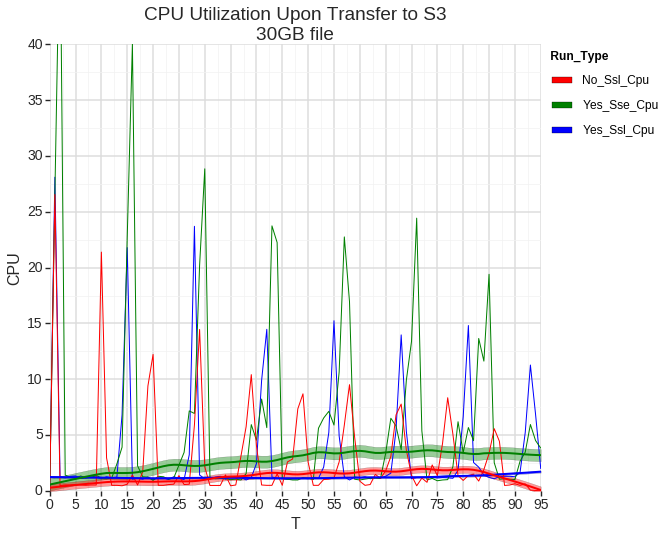

<ggplot: (8734008539940)>

In [166]:
p = ggplot(aes(x='t', y='cpu', color='run_type', fill='run_type'), data=df)
s = p +\
    geom_line() +\
    stat_smooth( size=2,span=.25, method='loess', se=True) +\
    xlim(0,95) + ylim(0,40) + xlab("T") +\
    ylab("CPU") + ggtitle("CPU Utilization Upon Transfer to S3\n30GB file") +\
    scale_color_manual(values=["red", "green", "blue"])+theme_seaborn(context='talk',style="whitegrid")
#ggsave("/tmp/foo.png",s,dpi=96)
#data
s


/home/psoutham/.apps/anaconda3/envs/bunnies/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


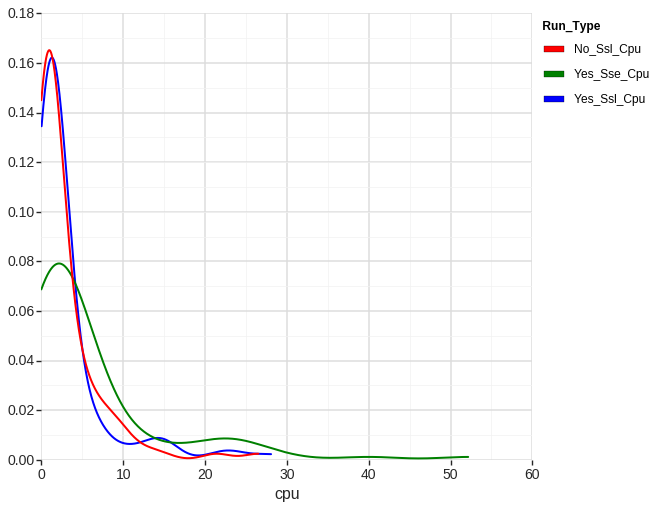

<ggplot: (-9223363302846026310)>

In [167]:
ggplot(aes(x='cpu',  color='run_type'), data=df) +\
  geom_density(alpha=.5, size=2)+scale_color_manual(values=["red", "green", "blue"])+theme_seaborn(context='talk',style="whitegrid")

/home/psoutham/.apps/anaconda3/envs/bunnies/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


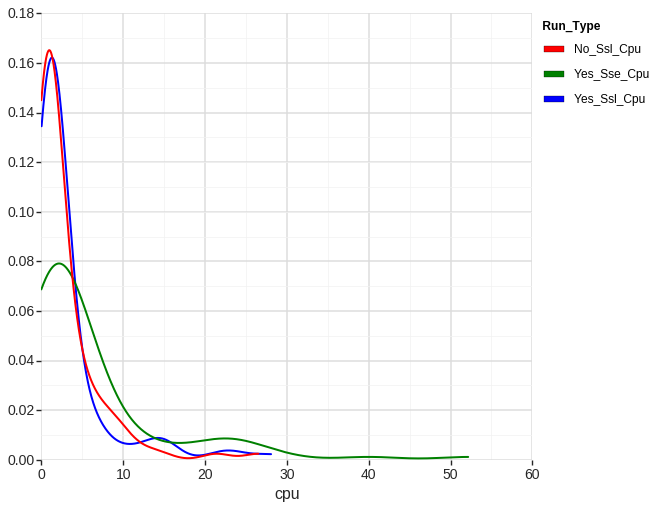

<ggplot: (8734008200403)>

In [168]:
ggplot(aes(x='cpu',  color='run_type'), data=data) +\
  geom_density(alpha=.5, size=2)+scale_color_manual(values=["red", "green", "blue"])+theme_seaborn(context='talk',style="whitegrid")

/home/psoutham/.apps/anaconda3/envs/bunnies/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
/home/psoutham/.apps/anaconda3/envs/bunnies/lib/python3.5/site-packages/ggplot/geoms/geom_bar.py:47: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  _reset = self.bottom == None or (self.ax != None and self.ax != ax)


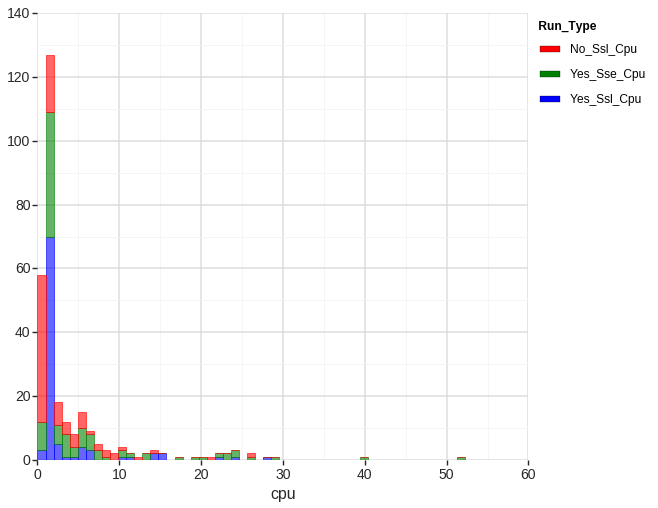

<ggplot: (8734008181312)>

In [169]:
ggplot(aes(x='cpu',  color='run_type',fill='run_type'), data=data) +\
  geom_histogram(binwidth=1,alpha=.6)+scale_color_manual(values=["red", "green", "blue"])+theme_seaborn(context='talk',style="whitegrid")

### Disk I/O

In [170]:
samples = []
for dev in ("eph-p", "eph-e", "io-e", "io-p"): #"gpt-e", 
    with open(os.path.join("reports", "bonnie.{}.txt".format(dev)), "r") as f:
        samples.extend(dev.split("-") + l.strip().split(",") for l in f.readlines()[1:])

In [171]:
bonnie = pd.DataFrame(samples)[[0,1,11, 12, 13,17, 18, 39, 40,]+list(range(42,50))]
bonnie.columns=["dev_type", "enc_flag", "put_block", "put_block_cpu", "rewrite", "get_block",
"get_block_cpu", "put_block_latency","rewrite_latency",
"get_block_latency","seeks_latency","seq_create_latency","seq_stat_latency","seq_del_latency","ran_create_latency","ran_stat_latency","ran_del_latency"]

for l in ("put_block", "get_block", "put_block_cpu", "get_block_cpu"):
    bonnie[l] = bonnie[l].apply(int)
    
for l in ("put_block_latency", "get_block_latency"):
    bonnie[l] = bonnie[l].apply(lambda x: int(x[:-2]) if x[-2:] == "us" else int(x[:-2])*1000)


In [172]:
bonnie.head()

,dev_type,enc_flag,put_block,put_block_cpu,rewrite,get_block,get_block_cpu,put_block_latency,rewrite_latency,get_block_latency,seeks_latency,seq_create_latency,seq_stat_latency,seq_del_latency,ran_create_latency,ran_stat_latency,ran_del_latency
0,eph,p,439625,28,180121,439533,14,22803,458ms,20886,4909us,136ms,274us,347ms,152ms,41us,282ms
1,eph,p,440489,29,181749,439541,14,26011,378ms,15698,389us,138ms,272us,253ms,138ms,49us,287ms
2,eph,p,433757,28,178483,439745,14,26556,403ms,9400,575us,154ms,447us,215ms,137ms,47us,244ms
3,eph,p,406842,27,178898,439132,14,38160,404ms,21083,2004us,141ms,272us,231ms,162ms,49us,301ms
4,eph,p,407786,27,180905,428006,13,28688,432ms,21548,1731us,155ms,272us,300ms,150ms,48us,289ms


/home/psoutham/.apps/anaconda3/envs/bunnies/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


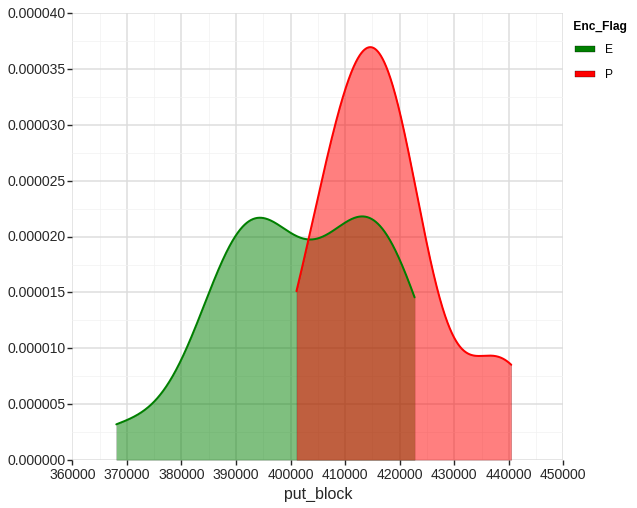

<ggplot: (8734046119856)>

In [173]:
ggplot(aes(x="put_block", color="enc_flag",fill="enc_flag"), data=bonnie[bonnie.dev_type == "eph"]) +\
 geom_density(alpha=.5, size=2) +scale_color_manual(values=["green", "red"])+theme_seaborn(context='talk',style="whitegrid")

/home/psoutham/.apps/anaconda3/envs/bunnies/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
/home/psoutham/.apps/anaconda3/envs/bunnies/lib/python3.5/site-packages/ggplot/ggplot.py:200: RuntimeWarning: Facetting is currently not supported with geom_bar. See
                    https://github.com/yhat/ggplot/issues/196 for more information
  warnings.warn(msg, RuntimeWarning)
/home/psoutham/.apps/anaconda3/envs/bunnies/lib/python3.5/site-packages/ggplot/geoms/geom_bar.py:47: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  _reset = self.bottom == None or (self.ax != None and self.ax != ax)


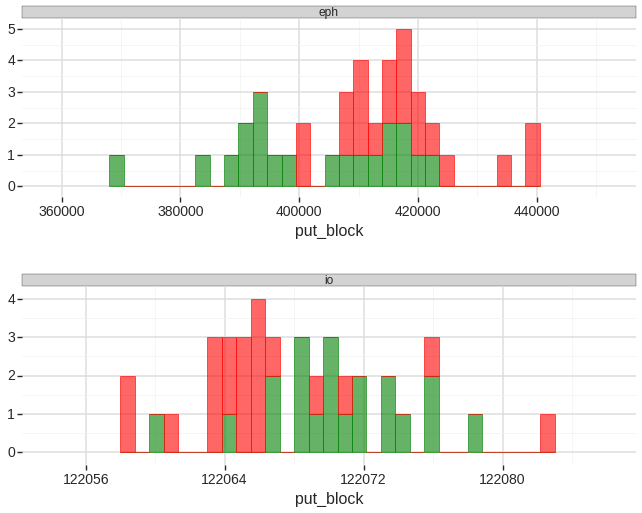

<ggplot: (-9223363302846607742)>

In [174]:
ggplot(aes(x="put_block", color="enc_flag", fill="enc_flag"), data=bonnie) +\
  geom_histogram(alpha=.6) +\
  facet_wrap("dev_type") +scale_color_manual(values=["green", "red"])+theme_seaborn(context='talk',style="whitegrid")

/home/psoutham/.apps/anaconda3/envs/bunnies/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


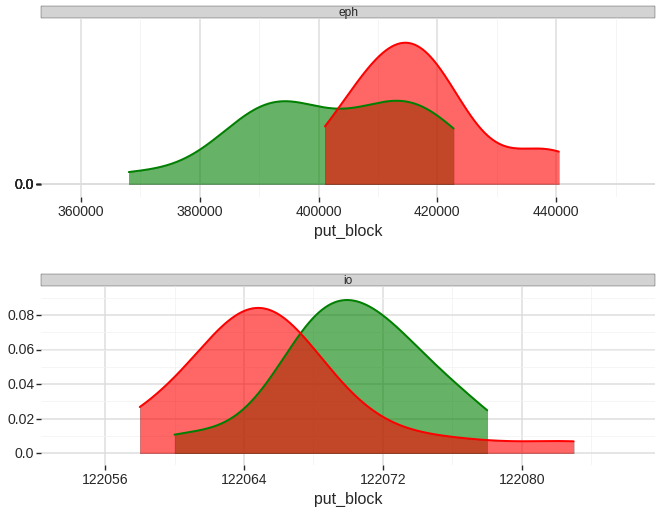

<ggplot: (-9223363302846117141)>

In [175]:
ggplot(aes(x="put_block", color="enc_flag", fill="enc_flag"), data=bonnie) +\
  geom_density(alpha=.6, size=2) +\
    facet_wrap("dev_type")+scale_color_manual(values=["green", "red"])+theme_seaborn(context='talk',style="whitegrid")

/home/psoutham/.apps/anaconda3/envs/bunnies/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
/home/psoutham/.apps/anaconda3/envs/bunnies/lib/python3.5/site-packages/ggplot/ggplot.py:200: RuntimeWarning: Facetting is currently not supported with geom_bar. See
                    https://github.com/yhat/ggplot/issues/196 for more information
  warnings.warn(msg, RuntimeWarning)
/home/psoutham/.apps/anaconda3/envs/bunnies/lib/python3.5/site-packages/ggplot/geoms/geom_bar.py:47: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  _reset = self.bottom == None or (self.ax != None and self.ax != ax)


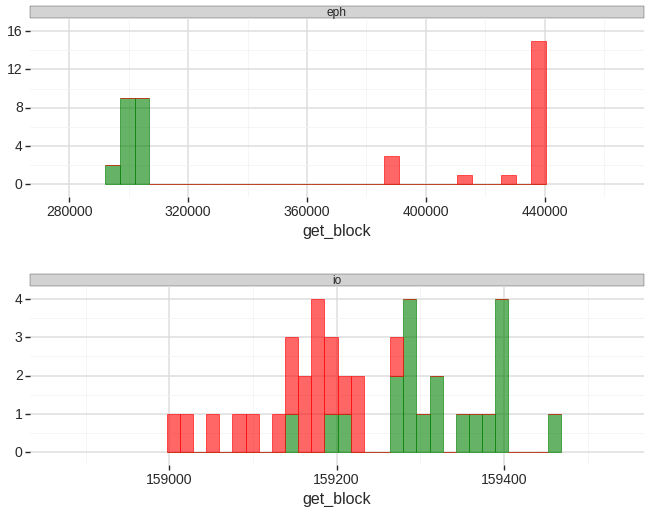

<ggplot: (8734009530267)>

In [176]:
p = ggplot(aes(x="get_block", color="enc_flag", fill="enc_flag"), data=bonnie) +\
  geom_histogram(alpha=.6) + facet_wrap("dev_type") +scale_color_manual(values=["green", "red"])+\
    theme_seaborn(context='talk',style="whitegrid")
p

/home/psoutham/.apps/anaconda3/envs/bunnies/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


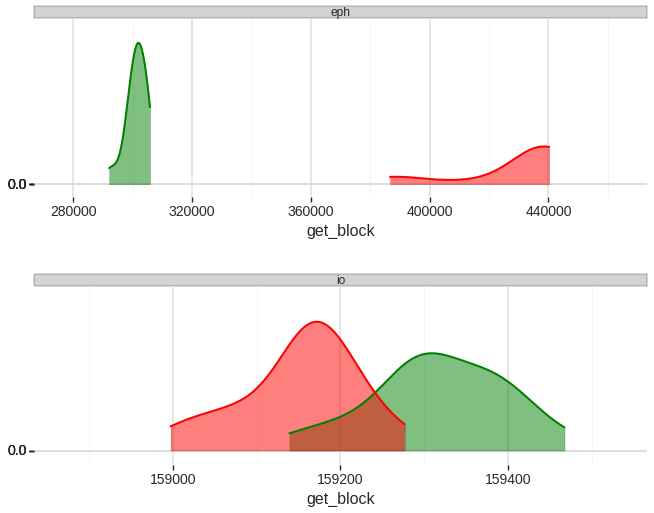

<ggplot: (8734009267411)>

In [177]:
p = ggplot(aes(x="get_block", color="enc_flag", fill="enc_flag"), data=bonnie)

p+geom_density(alpha=.5, size=2) +\
    facet_wrap("dev_type") + scale_color_manual(values=["green", "red"])+ theme_seaborn(style="whitegrid",context='talk')